# Predicting the Value of a Jeopardy! Question using Logistic Regression

In this notebook, we aim to build a classification model that takes a Jeopardy! question as input and predicts the value for which the question was posed. Value is used as a proxy for question difficulty.

In [73]:
import torch
import torchtext
import torchdata
import portalocker
import json
import pandas as pd
from torch.utils.data import Dataset
from torch.utils.data import TensorDataset, DataLoader
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

In [74]:
filename = 'jeopardy_csv.csv'

with open(filename, 'r', encoding='iso-8859-1') as f:
    df = pd.read_csv(f)

df

,Show Number,Air Date,Round,Category,Value,Question,Answer
0,4680,2004-12-31,Jeopardy!,HISTORY,$200,"For the last 8 years of his life, Galileo was ...",Copernicus
1,4680,2004-12-31,Jeopardy!,ESPN's TOP 10 ALL-TIME ATHLETES,$200,No. 2: 1912 Olympian; football star at Carlisl...,Jim Thorpe
2,4680,2004-12-31,Jeopardy!,EVERYBODY TALKS ABOUT IT...,$200,The city of Yuma in this state has a record av...,Arizona
3,4680,2004-12-31,Jeopardy!,THE COMPANY LINE,$200,"In 1963, live on ""The Art Linkletter Show"", th...",McDonald's
4,4680,2004-12-31,Jeopardy!,EPITAPHS & TRIBUTES,$200,"Signer of the Dec. of Indep., framer of the Co...",John Adams
...,...,...,...,...,...,...,...
216925,4999,2006-05-11,Double Jeopardy!,RIDDLE ME THIS,$2000,This Puccini opera turns on the solution to 3 ...,Turandot
216926,4999,2006-05-11,Double Jeopardy!,"""T"" BIRDS",$2000,In North America this term is properly applied...,a titmouse
216927,4999,2006-05-11,Double Jeopardy!,AUTHORS IN THEIR YOUTH,$2000,"In Penny Lane, where this ""Hellraiser"" grew up...",Clive Barker
216928,4999,2006-05-11,Double Jeopardy!,QUOTATIONS,$2000,"From Ft. Sill, Okla. he made the plea, Arizona...",Geronimo


In [75]:
df = df[[' Value', ' Question']]
df = df.rename(columns={' Question': 'Question',' Value': 'Value'})
df.head()

,Value,Question
0,$200,"For the last 8 years of his life, Galileo was ..."
1,$200,No. 2: 1912 Olympian; football star at Carlisl...
2,$200,The city of Yuma in this state has a record av...
3,$200,"In 1963, live on ""The Art Linkletter Show"", th..."
4,$200,"Signer of the Dec. of Indep., framer of the Co..."


In [76]:
encode_dict = {}

def encode_value(x):
    if x not in encode_dict.keys():
        encode_dict[x]=len(encode_dict)
    return encode_dict[x]

df['ENCODE_VAL'] = df['Value'].apply(lambda x: encode_value(x))
df['ENCODE_VAL'].unique()

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149], dtype=int64)

In [77]:
df

,Value,Question,ENCODE_VAL
0,$200,"For the last 8 years of his life, Galileo was ...",0
1,$200,No. 2: 1912 Olympian; football star at Carlisl...,0
2,$200,The city of Yuma in this state has a record av...,0
3,$200,"In 1963, live on ""The Art Linkletter Show"", th...",0
4,$200,"Signer of the Dec. of Indep., framer of the Co...",0
...,...,...,...
216925,$2000,This Puccini opera turns on the solution to 3 ...,8
216926,$2000,In North America this term is properly applied...,8
216927,$2000,"In Penny Lane, where this ""Hellraiser"" grew up...",8
216928,$2000,"From Ft. Sill, Okla. he made the plea, Arizona...",8


In [78]:
# split into train, valid and test dataset
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(df, train_size=0.9, test_size=0.1, random_state = 200)

In [79]:
train_iter = iter(train_data.Question)

In [80]:
tokenizer = get_tokenizer('basic_english')
def yield_tokens(train_iter):
    for text in train_iter:
        yield tokenizer(text)

vocab = build_vocab_from_iterator(
    yield_tokens(train_iter), specials=["<unk>"], min_freq=1000)

In [81]:
from sklearn.feature_extraction.text import TfidfVectorizer

tokenizer = get_tokenizer('basic_english')

tfidf_vectorizer = TfidfVectorizer(tokenizer=tokenizer, max_features=len(vocab))
tfidf_vectorizer.fit(train_data['Question'])

inputs = tfidf_vectorizer.transform(train_data['Question'])

c:\Users\sabri\.conda\envs\capp30255\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [82]:
test_inputs = tfidf_vectorizer.transform(test_data['Question'])

In [83]:
# split training data further into train and validation set
targets = train_data.ENCODE_VAL
train_inputs, val_inputs, train_targets, val_targets = train_test_split(inputs, targets, test_size = 0.2)
test_targets = test_data.ENCODE_VAL

In [84]:
# convert into pytorch tensors
train_input_tensors = torch.tensor(train_inputs.toarray()).float()
val_input_tensors = torch.tensor(val_inputs.toarray()).float()
test_input_tensors = torch.tensor(test_inputs.toarray()).float()

train_target_tensors = torch.tensor(train_targets.values)
val_target_tensors = torch.tensor(val_targets.values)
test_target_tensors = torch.tensor(test_targets.values)

In [85]:
# create dataloaders
BATCH_SIZE = 64

train_ds = TensorDataset(train_target_tensors, train_input_tensors)
val_ds = TensorDataset(val_target_tensors, val_input_tensors)
test_ds = TensorDataset(test_target_tensors, test_input_tensors)

train_dataloader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=True)

In [86]:
len(train_ds)

156189

In [87]:
from torch import nn
import torch.nn.functional as F

class TFIDFClassifier(nn.Module):
    def __init__(self, num_labels, vocab_size):
        super(TFIDFClassifier, self).__init__()
        self.linear = nn.Linear(vocab_size, num_labels)
    
    def forward(self, vec):
        return F.log_softmax(self.linear(vec), dim=1)

In [88]:
num_labels = len(df['ENCODE_VAL'].unique())
vocab_size = len(vocab)
model = TFIDFClassifier(num_labels, vocab_size)

### Create function to train one epoch

In [89]:
import time

loss_function = torch.nn.NLLLoss()

def train_an_epoch(dataloader, optimizer):
    model.train() # Sets the module in training mode.
    log_interval = 500

    for idx, (label, text) in enumerate(dataloader):
        model.zero_grad()
        log_probs = model(text) # forward pass
        loss = loss_function(log_probs, label)
        loss.backward()
        optimizer.step()
        if idx % log_interval == 0 and idx > 0:
            print(f'At iteration {idx} the loss is {loss:.3f}.')

### Create function to compute accuracy

In [90]:
def get_accuracy(dataloader):
    model.eval() # switch to indicate that the model is not in training mode
    with torch.no_grad(): # disables gradient calculation (for when you are sure you will not call Tensor.backward()). This will reduce memory consumption.
        total_examples = 0
        correct = 0
        for labels, text in dataloader: # for each batch in dataloader
            total_examples += text.shape[0]
            probs = model(text)
            preds = probs.argmax(1)
            correct += (torch.eq(preds, labels)).sum().item()
        overall_accuracy = correct / total_examples
        return overall_accuracy


### Training

At iteration 500 the loss is 2.484.
At iteration 1000 the loss is 2.627.
At iteration 1500 the loss is 2.351.
At iteration 2000 the loss is 2.702.

After epoch 1 the validation accuracy is 0.135.

At iteration 500 the loss is 2.423.
At iteration 1000 the loss is 2.543.
At iteration 1500 the loss is 2.458.
At iteration 2000 the loss is 2.470.

After epoch 2 the validation accuracy is 0.192.

At iteration 500 the loss is 2.304.
At iteration 1000 the loss is 2.656.
At iteration 1500 the loss is 2.274.
At iteration 2000 the loss is 2.518.

After epoch 3 the validation accuracy is 0.188.

At iteration 500 the loss is 2.411.
At iteration 1000 the loss is 2.349.
At iteration 1500 the loss is 2.610.
At iteration 2000 the loss is 2.254.

After epoch 4 the validation accuracy is 0.183.

At iteration 500 the loss is 2.329.
At iteration 1000 the loss is 2.437.
At iteration 1500 the loss is 2.375.
At iteration 2000 the loss is 2.400.

After epoch 5 the validation accuracy is 0.185.

At iteration 50

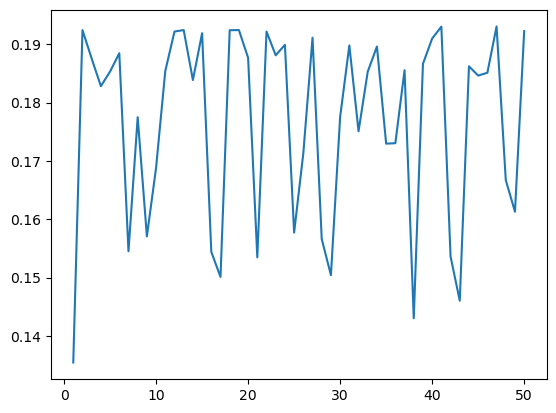

In [91]:
import matplotlib.pyplot as plt
%matplotlib inline

EPOCHS = 50
optimizer = torch.optim.SGD(model.parameters(), lr=3)

accuracies=[]
for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    train_an_epoch(train_dataloader, optimizer)
    accuracy = get_accuracy(valid_dataloader)
    accuracies.append(accuracy)
    time_taken = time.time() - epoch_start_time
    print()
    print(f'After epoch {epoch} the validation accuracy is {accuracy:.3f}.')
    print()
    
plt.plot(range(1, EPOCHS+1), accuracies)

In [92]:
test_accuracy = get_accuracy(test_dataloader)
print("test accuracy from model trained on 50 epochs:", test_accuracy)

test accuracy from model trained on 50 epochs: 0.1938874291246024
